In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector

from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor



from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score

In [155]:
pd.set_option("display.max_columns", 100)

### Import Data

**What the columns of our DataFrame mean**
* price: price in US dollars (\$326–\$18,823)
* carat: weight of the diamond (0.2–5.01)
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond colour, from D (best) to J (worst)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x: length in mm (0–10.74)
* y: width in mm (0–58.9)
* z: depth in mm (0–31.8)
* depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79)
* table: width of top of diamond relative to widest point (43–95)

In [156]:
df = sns.load_dataset("diamonds")

In [157]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Explore Data

In [158]:
df.shape

(53940, 10)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


#### Categories features

In [160]:
df.describe(include="category")

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


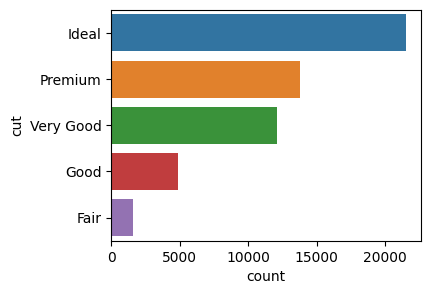

There are 0 NaN values in cut


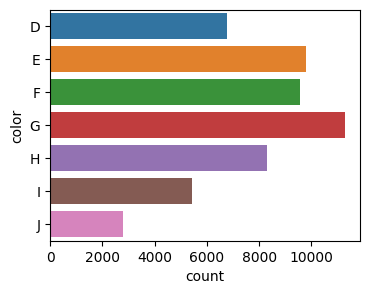

There are 0 NaN values in color


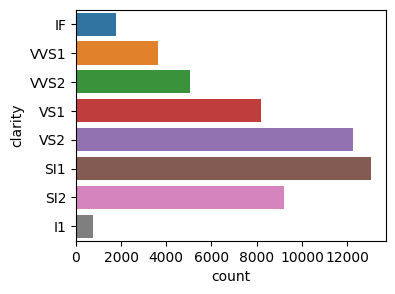

There are 0 NaN values in clarity


In [161]:
cat_feat_l = df.dtypes[df.dtypes == "category"].index
for feature in cat_feat_l :
    plt.figure(figsize=(4,3))
    sns.countplot(data=df,y=feature)
    plt.show()
    print(f"There are {df[feature].isna().sum()} NaN values in {feature}")

#### Numerical features

In [163]:
num_feat_l = df.dtypes[(df.dtypes == "float64") | (df.dtypes == "int64")].index
for feature in num_feat_l:
    # plt.figure(figsize=(6,4))
    # sns.histplot(data=df,x=feature,bins=50)
     print(f"There are {df[feature].isna().sum()} NaN values in {feature}");

There are 0 NaN values in carat
There are 0 NaN values in depth
There are 0 NaN values in table
There are 0 NaN values in price
There are 0 NaN values in x
There are 0 NaN values in y
There are 0 NaN values in z


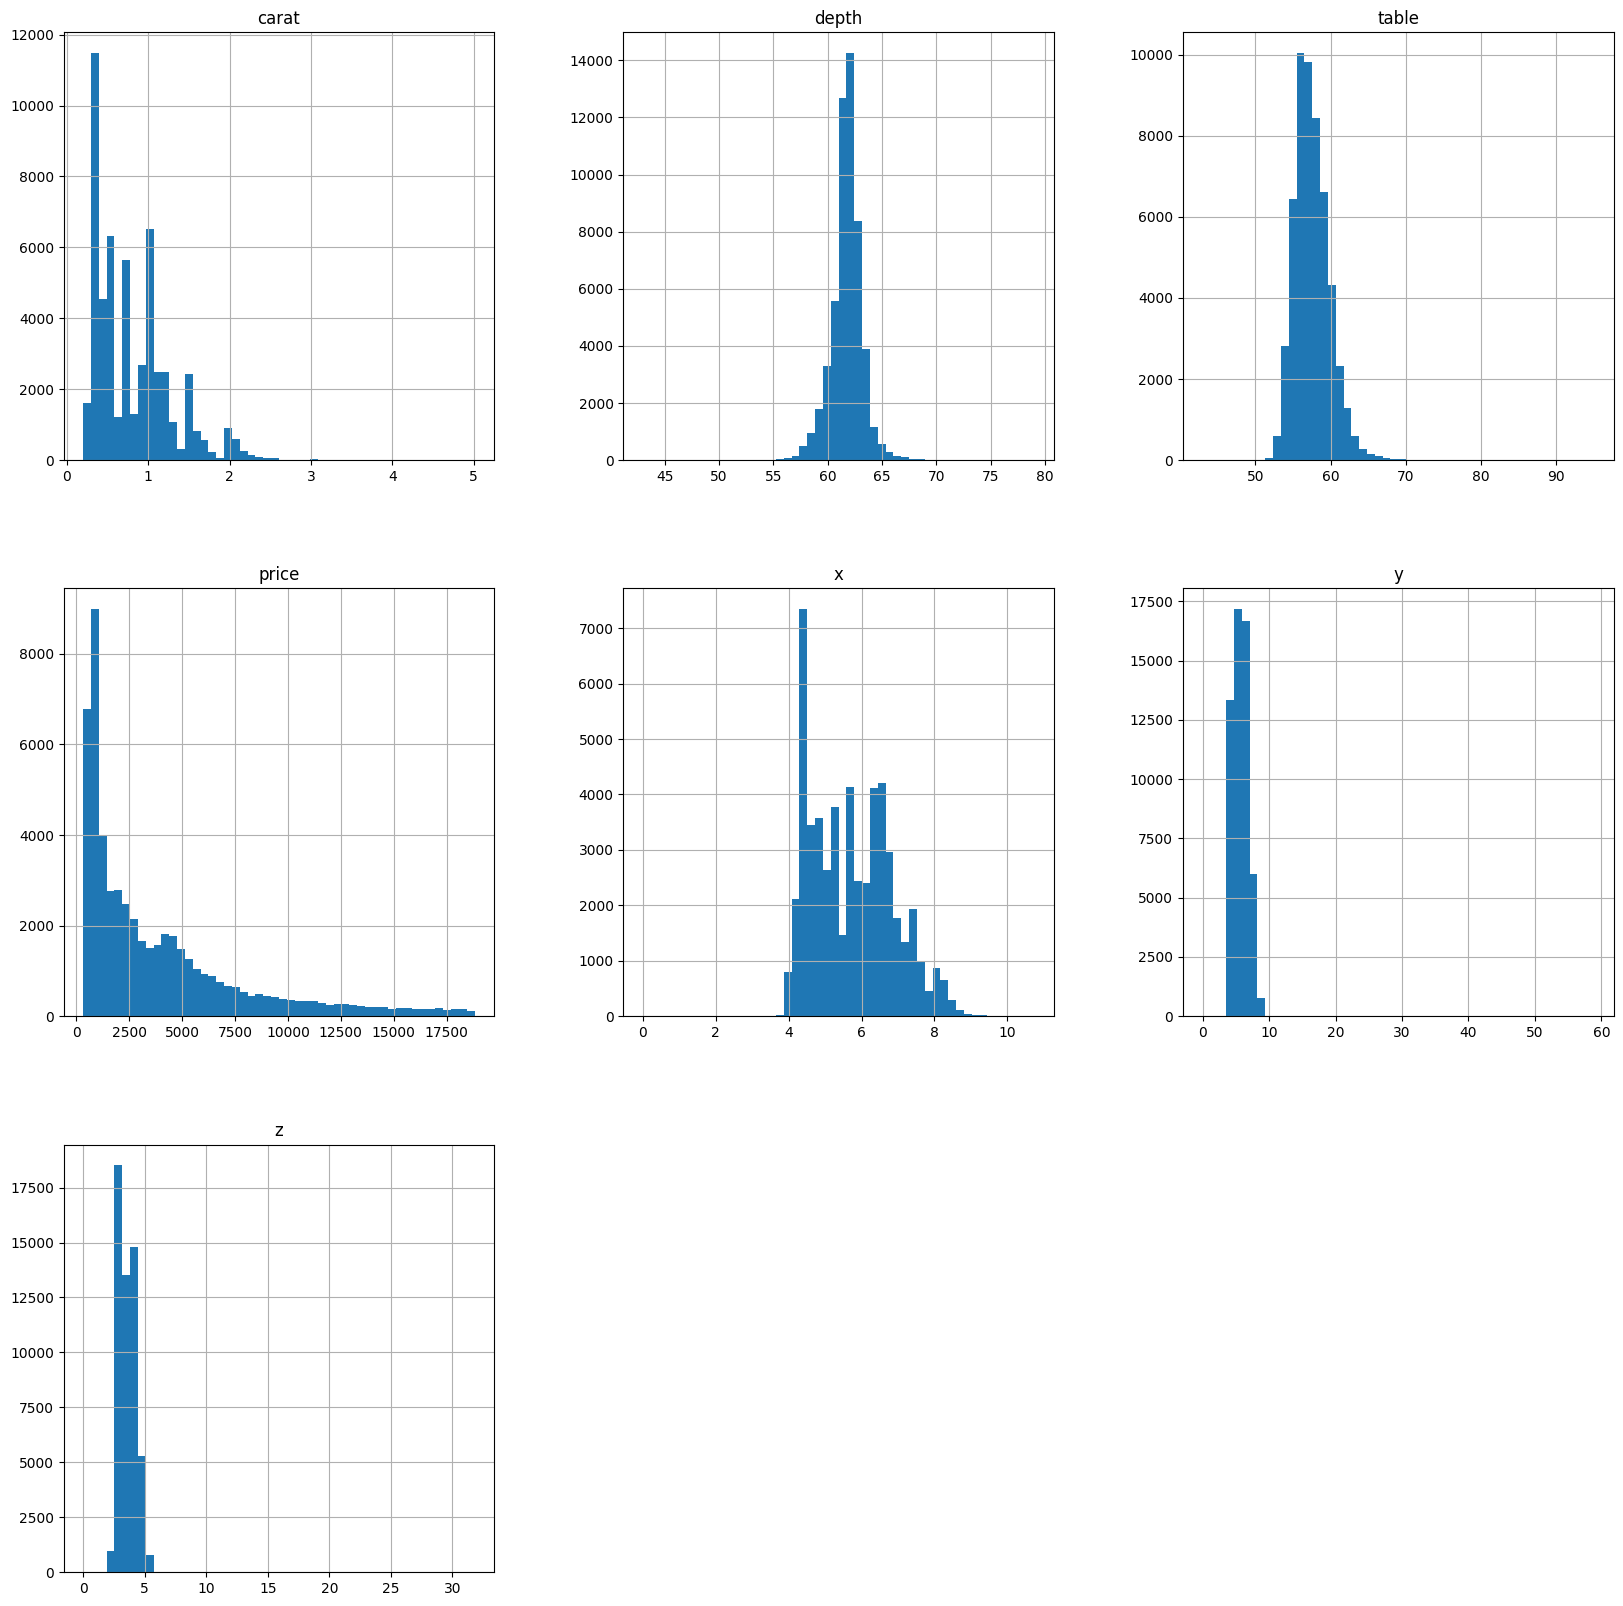

In [165]:
df.hist(figsize=(20,20),bins=50);

##### Remove meaningless observations
ie x,y,z <= 0

In [129]:
df.shape

(53940, 10)

In [171]:
df=df.loc[(df.x > 0)&(df.y>0)&(df.z>0)]

#####  Remove Outliers

In [173]:
num_feat_l = df.dtypes[(df.dtypes != "category")].index
num_feat_l

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')

In [174]:
def analyze_outliers(df,col,action="keep"):
    Q1   = col.quantile(0.25)
    Q3   = col.quantile(0.75)
    IQR = Q3 - Q1
    num_inliers =((col >= (Q1 - 1.5*IQR)) & (col <= (Q3 + 1.5*IQR))).sum()
    num_outliers = df.shape[0]-num_inliers
    per_outliers = round((num_outliers/df.shape[0])*100,2)
    print(f'''{num_outliers} out of {df.shape[0]} are outliers from {col.name}, ie {per_outliers}%''')
    if action == "delete":
        df=df.loc[((col >= (Q1 - 1.5*IQR)) & (col <= (Q3 + 1.5*IQR)))]
    return df

In [178]:
for col in num_feat_l:
    df=analyze_outliers(df,df[col],"delete")

1883 out of 53920 are outliers from carat, ie 3.49%
2794 out of 52037 are outliers from depth, ie 5.37%
342 out of 49243 are outliers from table, ie 0.69%
2368 out of 48901 are outliers from price, ie 4.84%
0 out of 46533 are outliers from x, ie 0.0%
1 out of 46533 are outliers from y, ie 0.0%
2 out of 46532 are outliers from z, ie 0.0%


In [179]:
df.shape

(46530, 10)

#### Coorelation

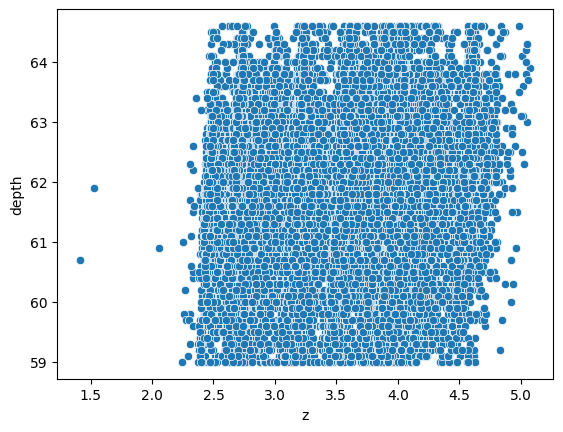

In [180]:
sns.scatterplot(data=df, x= "z",y="depth");

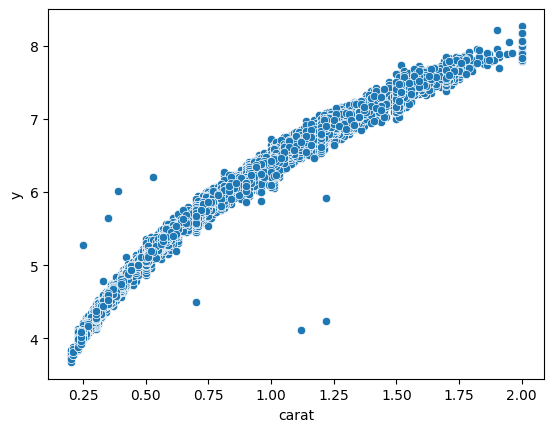

In [181]:
sns.scatterplot(data=df,x="carat",y="y");

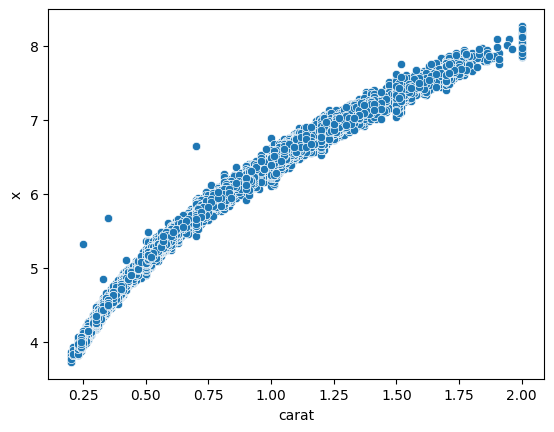

In [182]:
sns.scatterplot(data=df,x="carat",y="x");

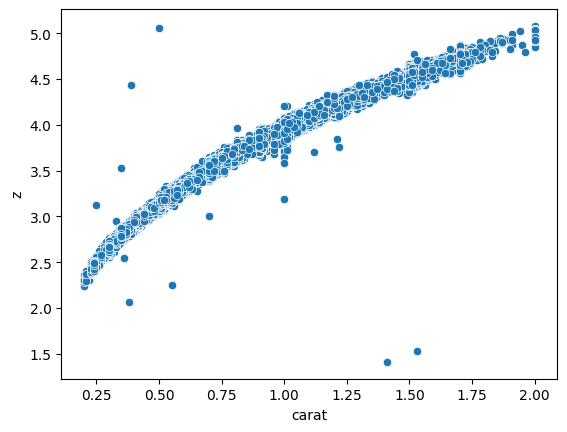

In [183]:
sns.scatterplot(data=df,x="carat",y="z");

### Split data

In [184]:
y= df.pop("price")
X= df.copy()

In [193]:
cat_feat_l = X.dtypes[X.dtypes == "category"].index
num_feat_l = X.dtypes[X.dtypes != "category"].index

In [195]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=123)

### Baseline Pipeline

In [199]:
#* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
#* color: diamond colour, from D (best) to J (worst)
#* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
cut_l = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_l =["J","I","H","G","F","E","D"]
clarity_l =["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
encode_cat = OrdinalEncoder(categories=[cut_l,color_l,clarity_l])
dtr = DecisionTreeRegressor()
knnr = KNeighborsRegressor()

preprocess = ColumnTransformer(transformers=[("encode_cat",encode_cat,cat_feat_l),("passthrough","passthrough",num_feat_l)])
pipe_all_dtr = Pipeline(steps=[("preprocess",preprocess),("dtr",dtr)])
pipe_all_knnr = Pipeline(steps=[("preprocess",preprocess),("knnr",knnr)])

In [200]:
pipe_all_dtr.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encode_cat',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('passthrough', 'passthrough',
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('dtr', DecisionTreeRegressor())])

In [201]:
pipe_all_knnr.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encode_cat',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('passthrough', 'passthrough',
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('knnr', KNeighborsRegressor())])

#### Evaluation

In [208]:
performances = pd.DataFrame(columns=["mae", "mse","mape","r2"])

In [209]:
performances.loc["base_dtr", "mae"] = mean_absolute_error(y_test,pipe_all_dtr.predict(X_test))
performances.loc["base_dtr", "mse"] = mean_squared_error(y_test,pipe_all_dtr.predict(X_test))
performances.loc["base_dtr", "mape"] = mean_absolute_percentage_error(y_test,pipe_all_dtr.predict(X_test))
performances.loc["base_dtr", "r2"] = r2_score(y_test,pipe_all_dtr.predict(X_test))

In [210]:
performances.loc["base_knnr", "mae"] = mean_absolute_error(y_test,pipe_all_knnr.predict(X_test))
performances.loc["base_knnr", "mse"] = mean_squared_error(y_test,pipe_all_knnr.predict(X_test))
performances.loc["base_knnr", "mape"] = mean_absolute_percentage_error(y_test,pipe_all_knnr.predict(X_test))
performances.loc["base_knnr", "r2"] = r2_score(y_test,pipe_all_knnr.predict(X_test))

In [211]:
performances

,mae,mse,mape,r2
base_dtr,254.019181,229051.101306,0.079666,0.966327
base_knnr,327.842811,305726.580434,0.123583,0.955055


### Pipeline

#### Encode

In [137]:
X.color.unique()

['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']

In [138]:
X.cut.unique()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

In [139]:
#* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
#* color: diamond colour, from D (best) to J (worst)
#* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
cut_l = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_l =["J","I","H","G","F","E","D"]
clarity_l =["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

In [148]:
encode_cat = OrdinalEncoder(categories=[cut_l,color_l,clarity_l])
scale = StandardScaler()
selectfeat= 
model = DecisionTreeRegressor()

preprocess = ColumnTransformer(transformers=[("encode_cat",encode_cat,cat_feat_l),("passthrough","passthrough",num_feat_l)])
pipe_all = Pipeline(steps=[("preprocess",preprocess),("scale",scale),("model",model)])

In [149]:
pipe_all.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encode_cat',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('passthrough', 'passthrough',
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('scale', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [ ]:
y_test_pred = pipe_all.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test,y_test_pred)
mse = mean_squared_error(y_test,y_test_pred)